In [35]:
# importing dependencies for MediaCloud API
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import mediacloud.api
from dateutil import parser
import time
import matplotlib.pyplot as plt

# loading config from .env file
load_dotenv()

True

In [2]:
# reading API key from .env
mc_api_key = os.getenv("MC_API_KEY")

# instantiating MediaCloud API
mc = mediacloud.api.MediaCloud(mc_api_key)
mediacloud.__version__

'3.12.4'

In [ ]:
# verifying API connection by printing some high-level stats
mc.stats()

## Story count for multiple sources:

In [75]:
# building a function to search a string among the sources given
def search_sources(query, sources, date_range=None, api_key=None, verbose=False):
    # ensuring the query is a string
    query = str(query)
    
    # ensuring sources are given in a dict
    assert type(sources) == dict, "Please provide the sources in a dict, in the format <Source Name>: <MediaCloud ID>"
    
    # defining API key, instantiating MediaCloud API
    # if no API key is passed, function assumes API key is defined in .env file as MC_API_KEY
    if not api_key:
        api_key = os.getenv("MC_API_KEY")
    mc = mediacloud.api.MediaCloud(api_key)
    
    # formatting date range for API query
    if date_range:
        from datetime import datetime
        
        assert len(date_range) == 2, "Please provide both a start and end date for the date interval."
        start_date = parser.parse(date_range[0])
        end_date = parser.parse(date_range[1])
        api_date_range = mc.dates_as_query_clause(start_date, end_date)
        print(f"Query: {query}, between {start_date.strftime('%m/%d/%Y')} and {end_date.strftime('%m/%d/%Y')}\n")
    else:
        print(f"Query: {query}\n")
    
    # initializing dataframe to store the query data
    story_counts = pd.DataFrame(columns=["Name", "Relevant Stories", "Total Stories", "Attention (%)"])
    story_counts.index.name = "MediaCloud ID"
    
    # going through each source and querying relevant and total stories
    for source_name in sources:
        if verbose:
            print(f"{source_name}:")
        
        # defining queries for topic and total stories
        api_query = f'{query} and media_id:{sources[source_name]}'
        total_query = f'media_id:{sources[source_name]}'
        
        # including date range if passed into function
        if date_range:
            relevant_stories = mc.storyCount(api_query, api_date_range)['count']
            total_stories = mc.storyCount(total_query, api_date_range)['count']

        else:
            relevant_stories = mc.storyCount(api_query)['count']
            total_stories = mc.storyCount(total_query)['count']
        
        # appending data to dataframe
        try:
            attention = (relevant_stories / total_stories) * 100
        except ZeroDivisionError:
            attention = np.nan
        story_counts.loc[sources[source_name]] = [source_name, relevant_stories, total_stories, attention]
        
        # printing story count and attention
        if verbose:
            print(f"{relevant_stories} stories about {query}, {total_stories} total")
            if not np.isnan(attention):
                print(f"{attention}% of stories are about {query}\n")
            else:
                print("")
    
    return story_counts

In [4]:
# defining sources and ID's in MediaCloud API. Commented sources cannot be found in MediaCloud
sources = {
    "Washington Post": 2,
    "New York Times": 1,
    "USA Today": 4,
    "LA Times": 6,
    "Bloomberg": 40944,
    "Christian Science Monitor": 3,
    "New York Daily News": 8,
    "Star Ledger (NJ)": 16,
    "The Philadelphia Inquirer (PA)": 18,
    "The Pittsburgh Post-Gazette (PA)": 45,
    "PennLive/Patriot-News (PA)": 662863,
    "The Day (CT)": 76581,
    "Hartford Courant (CT)": 59,
    "Baltimore Sun (MD)": 34,
    "The Capital Gazette (MD)": 70310,
    "The Virginian-Pilot (VA)": 55,
    "The Richmond Times-Dispatch (VA)": 53,
    "Boston Globe (MA)": 15,
    "Portland Press Herald (ME)": 366984,
    "Houston Chronicle (TX)": 10,
    "Austin American Statesman (TX)": 62,
    "Atlanta Journal Constitution (GA)": 22916,
    "Raleigh News and Observer (NC)": 58,
    "The Cleveland Plain Dealer (OH)": 662541
}

In [6]:
# defining search strings
sep11_search = '"9/11"'

In [ ]:
# calling function
start_time = time.time()
df = search_sources(sep11_search, sources=sources, date_range=["8/1/2021", "9/24/2021"])
end_time = time.time()
print(f"Time: {end_time - start_time} s")
df.sort_values(by="Attention (%)", ascending=False)

In [ ]:
# testing outputs/formats of dates
test_date1 = parser.parse("8/1/2021")
test_date2 = parser.parse("9/23/2021")
test_range = mc.dates_as_query_clause(test_date1, test_date2)

In [ ]:
# sampling 20 stories from a source containing the search string
query = f'"9 11" and media_id:2'
stories = mc.storyList(query, test_range, sort=mc.SORT_RANDOM)
pd.DataFrame(stories)

In [ ]:
# retrieving word counts from a source containing the search string
query = f'"9 11" and media_id:2'
word_count = mc.wordCount(query, test_range)
# pd.DataFrame(word_count)

# building term/document matrix
story_count = mc.storyCount(query, test_range)["count"]
doc_term_matrix = mc.storyWordMatrix(query, test_range, rows=story_count)
doc_term_matrix["word_matrix"]

## Query formatting: OR testing/exploration

In [ ]:
# testing OR clause in search strings
query = '"9/11" OR "September 11th"'
date_range = test_range
api_query = f'{query} and media_id:2'
print(f"Query: {api_query}")
relevant_stories = mc.storyCount(api_query, date_range)['count']
print(f"Relevant: {relevant_stories}\n")

In [ ]:
?mc.storyCount

In [ ]:
query1 = '"September 11th"'
query2 = '"9/11"'
api_query1 = f'{query1} and media_id:2'
api_query2 = f'{query2} and media_id:2'
print(api_query1)
print(api_query2)
relevant_stories1 = mc.storyCount(api_query1, date_range)['count']
relevant_stories2 = mc.storyCount(api_query2, date_range)['count']
relevant_stories_or = mc.storyCount(f"{api_query1} OR {api_query2}", date_range)['count']

print(f"Relevant1: {relevant_stories1}")
print(f"Relevant2: {relevant_stories2}")
print(f"Or: {relevant_stories_or}")

## Attention over time plots:

In [115]:
# function to plot attention over time for one or more queries
def attention_plots(queries, media_id, date_range, api_key=None, split_on_or=True, fig_size=(8,4), verbose=False):
    # formatting query for plots
    if type(queries) == str:
        if split_on_or:
            queries = queries.split(" OR ")
        else:
            queries = [queries]
    else:
        assert type(queries)==list, "Please pass either a list or string of queries into this function."
    
    # defining API key, instantiating MediaCloud API
    # if no API key is passed, function assumes API key is defined in .env file as MC_API_KEY
    if not api_key:
        api_key = os.getenv("MC_API_KEY")
    mc = mediacloud.api.MediaCloud(api_key)
    
    # formatting date range for API query
    from datetime import datetime
    assert len(date_range) == 2, "Please provide both a start and end date for the date interval."
    start_date = parser.parse(date_range[0])
    end_date = parser.parse(date_range[1])
    api_date_range = mc.dates_as_query_clause(start_date, end_date)
    if verbose:
        print(f"Date range: {start_date.strftime('%m/%d/%Y')} to {end_date.strftime('%m/%d/%Y')}")
    
    # looping over each query and adding attention vs time plot to figure
    figure = plt.figure(figsize=fig_size)
    for query in queries:
        if verbose:
            print(f"Query: {query}")
        
        # defining query parameters
        relevant_query = f"{query} and media_id:{media_id}"
        total_query = f"media_id:{media_id}"
        
        # making API calls for relevant and total story counts (by day)
        relevant_results = mc.storyCount(relevant_query, api_date_range, split=True, split_period='day')['counts']
        if not relevant_results:
            print(f"0 results for {query} between {start_date.strftime('%m/%d/%Y')} and {end_date.strftime('%m/%d/%Y')}.")
            continue
        total_results = mc.storyCount(total_query, api_date_range, split=True, split_period='day')['counts']
        
        # creating dataframes for query and total results
        relevant_df = pd.DataFrame(relevant_results)
        relevant_df["date"] = pd.to_datetime(relevant_df["date"])
        total_df = pd.DataFrame(total_results)
        total_df["date"] = pd.to_datetime(total_df["date"])
        
        # joining dataframes on date, filling missing dates from query with zeros
        join_df = total_df.merge(relevant_df, how="outer", on="date", suffixes=("_total", "_relevant"))
        join_df["count_relevant"] = join_df["count_relevant"].fillna(0).astype(int)
        join_df = join_df[["date", "count_total", "count_relevant"]]
        
        # calculating attention
        join_df["attention"] = (join_df["count_relevant"] / join_df["count_total"]) * 100
        
        # plotting attention over time
        plt.plot(join_df["date"], join_df["attention"], '-', label=query)
    
    # setting parameters for plot
    plt.suptitle("Attention over time")
    plt.legend(loc=0)
    plt.xlabel("Date")
    plt.ylabel("Attention in source (%)")
    plt.xticks(rotation=60)
    plt.show()
    return figure

In [118]:
# testing attention_plots function
queries = ['"9/11"', '"afghanistan"']
queries = '"9/11" OR "afghanistan"'
date_range = ["8/1/2021", "9/28/2021"]
test_fig = attention_plots(queries, media_id=2, date_range=date_range)

MCException: ('Error - got a HTTP status code of 429 with the message "Too Many Requests", body: {"error":"Error(s): User exceeded weekly requests limit of 10000. You have exceeded your quota of requests or stories. Please contact\\ninfo@mediacloud.org with quota questions.\\n"}', 429)

<Figure size 576x288 with 0 Axes>

In [104]:
type(test_fig)

matplotlib.figure.Figure

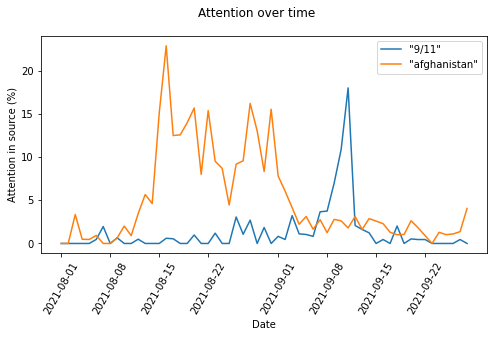

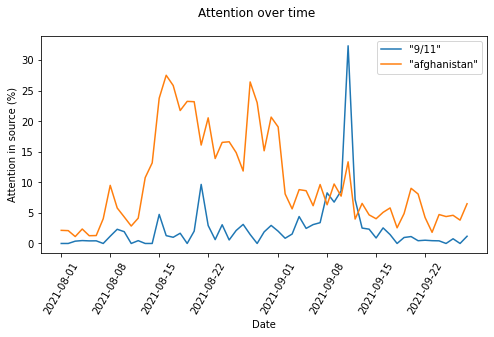

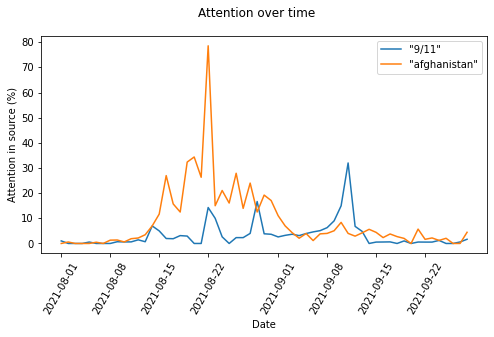

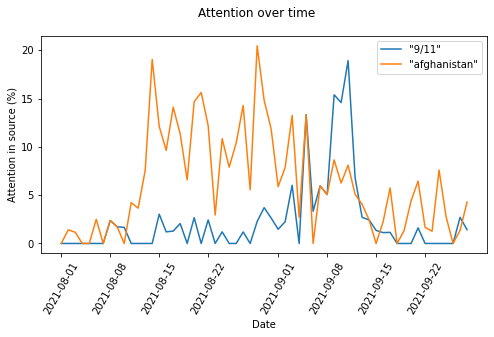

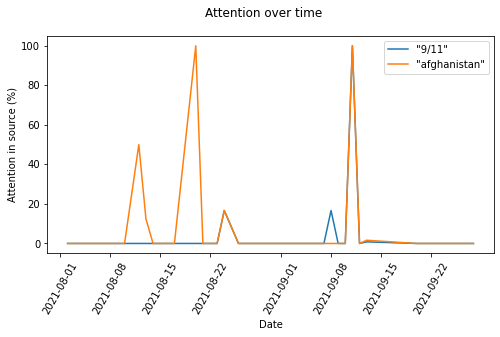

MCException: ('Error - got a HTTP status code of 429 with the message "Too Many Requests", body: {"error":"Error(s): User exceeded weekly requests limit of 10000. You have exceeded your quota of requests or stories. Please contact\\ninfo@mediacloud.org with quota questions.\\n"}', 429)

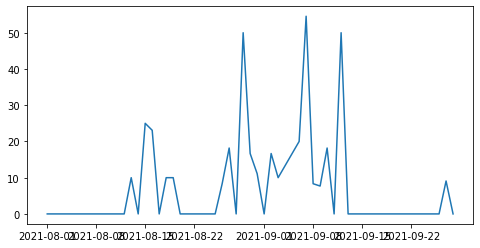

In [117]:
for i in sources:
    test_fig = attention_plots(queries, media_id=sources[i], date_range=date_range)